In [1]:
# Cell 1: Общее конфигурирование
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device("cpu")
print('Device:', device)
 
seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "pendulum"
ENV_ID = "InvertedDoublePendulum-v4"
# ENV_ID = "CartPole-v1"

Device: cpu


# Создание среды

In [2]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, render_mode=None, device=device, seed=seed)
env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


2025-08-22 23:14:47,615 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [3]:
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = 2*act_dim,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = act_dim
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
critic

ValueOperator(
    module=Sequential(
      (0): Linear(in_features=11, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
      (4): Linear(in_features=256, out_features=1, bias=True)
    ),
    device=cpu,
    in_keys=['observation'],
    out_keys=['state_value'])

# Collector

In [4]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss Function

In [5]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

gamma = 0.99
lmbda = 0.95

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=critic, average_gae=True
)

clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
entropy_eps = 1e-4

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

lr = 3e-4

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=total_frames // frames_per_batch, 
    eta_min=0.0
)

# Make Dirs

In [8]:
from __future__ import annotations
from dataclasses import dataclass, field


import sys, csv, json, platform, re
from typing import Dict, Any, Optional, List

import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

In [9]:
from dataclasses import dataclass
from pathlib import Path

# ---------- Paths & meta ----------
@dataclass
class RunPaths:
    root: Path
    run_dir: Path
    ckpt_dir: Path
    csv_train: Path
    csv_eval: Path
    tb_train: Path
    tb_eval: Path
    meta_yaml: Path

In [ ]:
from datetime import datetime

def make_run_name(algo: str, env: str) -> str:
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")  # локальное время машины
    safe_algo = re.sub(r"[^a-zA-Z0-9_\-]+", "_", algo)
    safe_env  = re.sub(r"[^a-zA-Z0-9_\-]+", "_", env)
    return f"{safe_algo}_{safe_env}_{ts}"


def setup_run(
    root: Path, algo: str, env: str, extra_meta: Optional[Dict[str, Any]] = None
) -> tuple[str, RunPaths, "CSVLogger", "CSVLogger", SummaryWriter, SummaryWriter]:
    run_name = make_run_name(algo, env)
    run_dir  = root / "runs" / run_name

    ckpt_dir = run_dir / "checkpoints"
    csv_dir  = run_dir / "csv_logs"
    tb_train = run_dir / "tb_logs" / "train"
    tb_eval  = run_dir / "tb_logs" / "eval"
    for d in (ckpt_dir, csv_dir, tb_train, tb_eval):
        d.mkdir(parents=True, exist_ok=True)

    paths = RunPaths(
        root=root, 
        run_dir=run_dir, 
        ckpt_dir=ckpt_dir,
        csv_train=csv_dir / "train.csv", 
        csv_eval=csv_dir / "eval.csv",
        tb_train=tb_train, 
        tb_eval=tb_eval, 
        meta_yaml=run_dir / "meta_info.yaml"
    )

    # meta_info.yaml — минимально полезные поля
    meta: Dict[str, Any] = {
        "algo_name": algo,
        "env_name": env,
        "run_name": run_name,
        "started_at": datetime.now().isoformat(timespec="seconds"),
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "torch": torch.__version__,
    }
    if extra_meta:
        meta.update(extra_meta)

    try:
        import yaml  # PyYAML
        with open(paths.meta_yaml, "w", encoding="utf-8") as f:
            yaml.safe_dump(meta, f, sort_keys=False, allow_unicode=True)
    except Exception:
        # fallback на JSON рядом, если PyYAML не установлен
        with open(paths.meta_yaml.with_suffix(".json"), "w", encoding="utf-8") as f:
            json.dump(meta, f, indent=2, ensure_ascii=False)

    # CSV loggers
    train_csv = CSVLogger(paths.csv_train, fieldnames=["frame", "reward_mean", "step_count_max", "lr"])
    eval_csv  = CSVLogger(paths.csv_eval,  fieldnames=["frame", "return_mean", "return_std", "max_episode_length"])

    # TensorBoard
    tbw_train = SummaryWriter(paths.tb_train.as_posix())
    tbw_eval  = SummaryWriter(paths.tb_eval.as_posix())

    return run_name, paths, train_csv, eval_csv, tbw_train, tbw_eval



# Logging

In [18]:

# ---------- CSV logger ----------
class CSVLogger:
    def __init__(self, filepath: Path, fieldnames: List[str]):
        self.filepath = Path(filepath)
        self.filepath.parent.mkdir(parents=True, exist_ok=True)
        self._file = self.filepath.open("a", newline="", encoding="utf-8")
        self.writer = csv.DictWriter(self._file, fieldnames=fieldnames)
        if self.filepath.stat().st_size == 0:
            self.writer.writeheader()
            self._file.flush()

    def log(self, row: Dict[str, Any]) -> None:
        self.writer.writerow(row)
        self._file.flush()

    def close(self) -> None:
        try:
            self._file.close()
        except Exception:
            pass


# ---------- TensorBoard & CSV logging helpers ----------
def log_train_step(tbw: SummaryWriter, csv_logger: CSVLogger, frame: int, reward_mean: float, step_count_max: int, lr: float) -> None:
    tbw.add_scalar("train/reward_mean",     reward_mean,    frame)
    tbw.add_scalar("train/step_count_max",  step_count_max, frame)
    tbw.add_scalar("train/lr",              lr,             frame)
    csv_logger.log({
        "frame": frame,
        "reward_mean": reward_mean,
        "step_count_max": step_count_max,
        "lr": lr,
    })


def log_eval_step(tbw: SummaryWriter, csv_logger: CSVLogger, frame: int, eval_results: Dict[str, Any]) -> None:
    # ожидаемые ключи: return_mean, return_std (если есть), max_episode_length / max_episode_lengh
    ret_mean = float(eval_results.get("return_mean", float("nan")))
    ret_std  = float(eval_results.get("return_std", float("nan")))
    max_len  = int(eval_results.get("max_episode_length", eval_results.get("max_episode_lengh", -1)))

    tbw.add_scalar("eval/return_mean", ret_mean, frame)
    if not (ret_std != ret_std):  # not NaN
        tbw.add_scalar("eval/return_std", ret_std, frame)
    tbw.add_scalar("eval/max_episode_length", max_len, frame)

    csv_logger.log({
        "frame": frame,
        "return_mean": ret_mean,
        "return_std": ret_std,
        "max_episode_length": max_len,
    })

# Progress Bar

In [19]:
def create_progress_bar(total_frames: int) -> tqdm:
    return tqdm(total=total_frames, dynamic_ncols=True, leave=True)


def update_progress_bar(pbar: tqdm, batch_frames: int, *, reward_mean: float, step_count_max: int, lr: float) -> None:
    inc = min(batch_frames, pbar.total - pbar.n)
    if inc > 0:
        pbar.update(inc)
    pbar.set_description(
        f"avg reward={reward_mean: 4.4f}, max step count: {step_count_max}, lr: {lr: 4.4f}"
    )


def close_run(train_csv: CSVLogger, eval_csv: CSVLogger, tb_train: SummaryWriter, tb_eval: SummaryWriter, pbar: Optional[tqdm] = None) -> None:
    train_csv.close()
    eval_csv.close()
    tb_train.flush(); tb_train.close()
    tb_eval.flush();  tb_eval.close()
    if pbar is not None:
        pbar.close()

# Checkpointing

In [20]:
@dataclass
class CheckpointManager:
    ckpt_dir: Path
    metric_key: str = "return_mean"
    mode: str = "max"  # "max" или "min"
    best_value: Optional[float] = None
    save_n_latest: Optional[int] = 10
    _history: List[Path] = field(default_factory=list)

    def _is_better(self, val: float) -> bool:
        if self.best_value is None:
            return True
        return (val > self.best_value) if self.mode == "max" else (val < self.best_value)

    def save_eval_ckpt(
        self,
        *,
        actor,
        optimizer,
        scheduler,
        loss_module,
        frame: int,
        metrics: Dict[str, Any],
        extra_state: Optional[Dict[str, Any]] = None,
    ) -> Dict[str, Any]:
        """Сохраняет checkpoints/last.pt, checkpoints/step_{frame}.pt и при улучшении — best.pt"""
        state = {
            "frame": frame,
            "metrics": metrics,
            "actor_state_dict": actor.state_dict() if hasattr(actor, "state_dict") else None,
            "optimizer_state_dict": optimizer.state_dict() if optimizer is not None else None,
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "loss_module_state_dict": loss_module.state_dict() if loss_module is not None else None,
            "torch_version": torch.__version__,
        }
        if extra_state:
            state.update(extra_state)

        self.ckpt_dir.mkdir(parents=True, exist_ok=True)

        last_path = self.ckpt_dir / "last.pt"
        step_path = self.ckpt_dir / f"step_{frame}.pt"
        torch.save(state, last_path)
        torch.save(state, step_path)
        self._history.append(step_path)

        # сдерживаем рост числа step_*.pt
        if self.save_n_latest is not None and len(self._history) > self.save_n_latest:
            old = self._history.pop(0)
            try:
                old.unlink(missing_ok=True)
            except Exception:
                pass

        result = {"is_best": False, "best_value": self.best_value}
        val = metrics.get(self.metric_key, None)
        if isinstance(val, (int, float)) and self._is_better(float(val)):
            self.best_value = float(val)
            torch.save(state, self.ckpt_dir / "best.pt")
            result.update({"is_best": True, "best_value": self.best_value})
        return result

# Training Loop

In [21]:
# Параметры запуска
from pathlib import Path
ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "pendulum"

# Настройка run-папки, логгеров и чекпоинтов
extra_meta = {
    "total_frames": int(total_frames),
    "frames_per_batch": int(frames_per_batch),
    "num_epochs": int(10),
    "sub_batch_size": int(64),
    # при желании добавьте seed, гиперпараметры и пр.
}
run_name, paths, train_csv, eval_csv, tb_train, tb_eval = setup_run(ROOT, ALGO_NAME, ENV_NAME, extra_meta)
ckpt_mgr = CheckpointManager(paths.ckpt_dir, metric_key="return_mean", mode="max", save_n_latest=10)

# Прогресс-бар
pbar = create_progress_bar(total_frames=total_frames)

max_grad_norm = 1.0
num_epochs = 10
sub_batch_size = 64

# Итерируемся по коллекторам, пока не наберём нужное число шагов
for i, tensordict_data in enumerate(collector):
    # === TRAIN ===
    for _ in range(num_epochs):
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())

        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    scheduler.step()  # Шаг LR-планировщика

    # === ЛОГ TRAIN ===
    reward_mean    = tensordict_data["next", "reward"].mean().item()
    step_count_max = tensordict_data["step_count"].max().item()
    lr_val         = float(optim.param_groups[0]["lr"])

    # корректное число фреймов в пачке
    batch_frames = int(tensordict_data.get(("next", "reward")).numel())

    # обновляем прогресс-бар и получаем текущий глобальный frame
    update_progress_bar(pbar, batch_frames, reward_mean=reward_mean, step_count_max=step_count_max, lr=lr_val)
    global_frame = int(pbar.n)  # используем число обработанных кадров как глобальный шаг

    # пишем train в TB+CSV (минимум шумных метрик)
    log_train_step(tb_train, train_csv, global_frame, reward_mean, step_count_max, lr_val)

    # === EVAL каждые 5 партий ===
    if (i + 1) % 5 == 0:
        eval_results = eval_policy(env, actor, episodes=5, progress=False)
        # Логи eval
        log_eval_step(tb_eval, eval_csv, global_frame, eval_results)

        # Чекпоинты — только на eval
        ckpt_info = ckpt_mgr.save_eval_ckpt(
            actor=actor,
            optimizer=optim,
            scheduler=scheduler,
            loss_module=loss_module,
            frame=global_frame,
            metrics=eval_results,
            extra_state={"run_name": run_name},
        )

        # Сообщение в pbar, не ломает отрисовку
        msg = (
            f"eval: avg reward = {eval_results.get('return_mean'):.4f}, "
            f"max episode length = {eval_results.get('max_episode_length', eval_results.get('max_episode_lengh', -1))}"
        )
        if ckpt_info.get("is_best"):
            msg += f" | NEW BEST (return_mean={ckpt_info['best_value']:.4f}) → checkpoints/best.pt"
        pbar.write(msg)

# Завершаем корректно
close_run(train_csv, eval_csv, tb_train, tb_eval, pbar)
print(f"Run saved to: {paths.run_dir}")


  0%|          | 0/10000 [00:00<?, ?it/s]

eval: avg reward = 118.4531, max episode length = 15 | NEW BEST (return_mean=118.4531) → checkpoints/best.pt
eval: avg reward = 153.8498, max episode length = 22 | NEW BEST (return_mean=153.8498) → checkpoints/best.pt
Run saved to: C:\Users\werna\Documents\GitHub\AgentsLab\runs\ppo_pendulum_20250822-231839


# Graphs

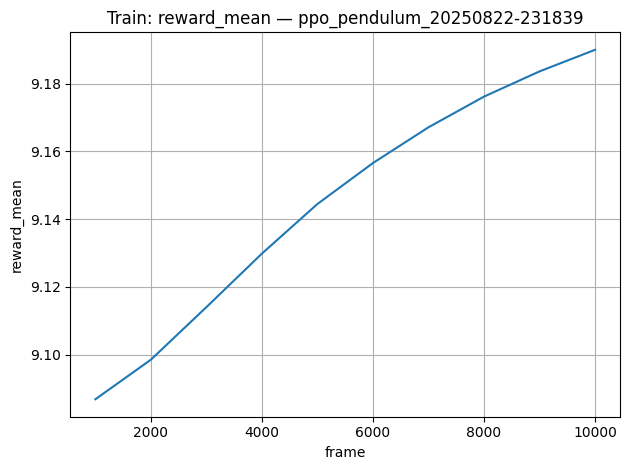

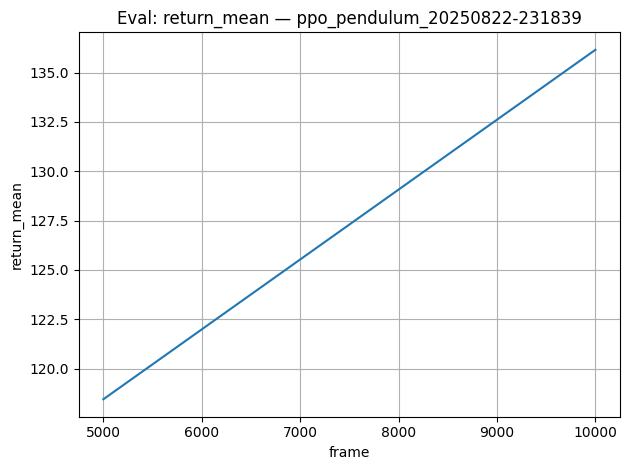

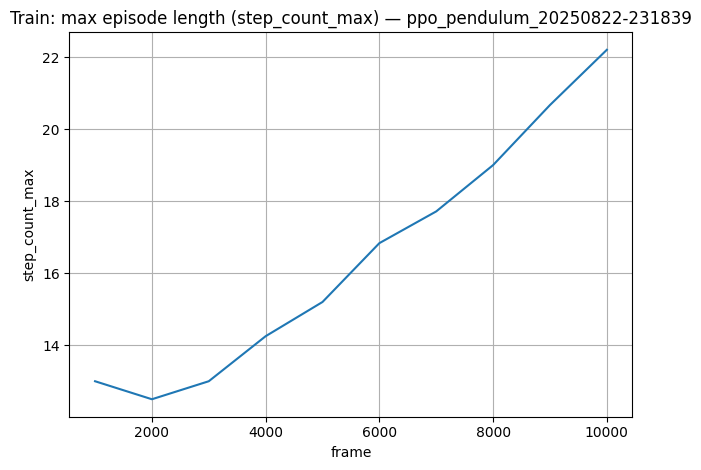

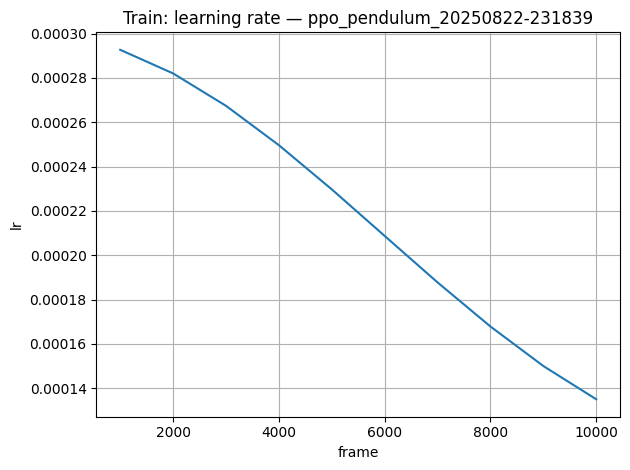

In [22]:
# Визуализация логов из CSV (train.csv, eval.csv)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Найти папку запуска ---
def _find_latest_run(root: Path, algo: str, env: str) -> Path | None:
    runs_dir = root / "runs"
    if not runs_dir.exists():
        return None
    pattern = re.compile(fr"^{re.escape(algo)}_{re.escape(env)}_\d{{8}}-\d{{6}}$")
    candidates = [p for p in runs_dir.iterdir() if p.is_dir() and pattern.match(p.name)]
    if not candidates:
        candidates = [p for p in runs_dir.iterdir() if p.is_dir()]
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0] if candidates else None

# --- Определяем run_dir (либо из предыдущей ячейки, либо ищем последний) ---
try:
    run_dir = paths.run_dir  # создано ранее функцией setup_run(...)
except NameError:
    try:
        ROOT
    except NameError:
        ROOT = Path("..").resolve()
    try:
        ALGO_NAME, ENV_NAME
    except NameError:
        ALGO_NAME, ENV_NAME = "ppo", "pendulum"
    run_dir = _find_latest_run(ROOT, ALGO_NAME, ENV_NAME)
    if run_dir is None:
        raise FileNotFoundError("Не найден ни один run в ROOT/runs")

csv_train_path = run_dir / "csv_logs" / "train.csv"
csv_eval_path  = run_dir / "csv_logs" / "eval.csv"

# --- Чтение CSV с валидацией и сортировкой по frame ---
def read_csv_safe(p: Path) -> pd.DataFrame:
    if not p.exists():
        print(f"Файл не найден: {p}")
        return pd.DataFrame()
    df = pd.read_csv(p)
    if "frame" in df.columns:
        df["frame"] = pd.to_numeric(df["frame"], errors="coerce")
        df = df.dropna(subset=["frame"]).astype({"frame": int}).sort_values("frame")
    return df

train_df = read_csv_safe(csv_train_path)
eval_df  = read_csv_safe(csv_eval_path)

# --- Параметры сглаживания ---
SMOOTH = 20  # окно скользящего среднего по точкам (1 = без сглаживания)

if not train_df.empty and SMOOTH > 1:
    for col in ["reward_mean", "step_count_max", "lr"]:
        if col in train_df.columns:
            train_df[col + "_sm"] = train_df[col].rolling(window=SMOOTH, min_periods=1).mean()

if not eval_df.empty and SMOOTH > 1:
    for col in ["return_mean", "return_std", "max_episode_length"]:
        if col in eval_df.columns:
            eval_df[col + "_sm"] = eval_df[col].rolling(window=SMOOTH, min_periods=1).mean()

# --- Построение графиков (каждый — отдельная фигура) ---
plt.figure()
if not train_df.empty and "reward_mean" in train_df.columns:
    y = train_df["reward_mean_sm"] if "reward_mean_sm" in train_df else train_df["reward_mean"]
    plt.plot(train_df["frame"], y)
    plt.title(f"Train: reward_mean — {run_dir.name}")
    plt.xlabel("frame"); plt.ylabel("reward_mean"); plt.grid(True); plt.tight_layout()
else:
    plt.title("Train: reward_mean — данных нет"); plt.tight_layout()

plt.figure()
if not eval_df.empty and "return_mean" in eval_df.columns:
    y = eval_df["return_mean_sm"] if "return_mean_sm" in eval_df else eval_df["return_mean"]
    plt.plot(eval_df["frame"], y)
    plt.title(f"Eval: return_mean — {run_dir.name}")
    plt.xlabel("frame"); plt.ylabel("return_mean"); plt.grid(True); plt.tight_layout()
else:
    plt.title("Eval: return_mean — данных нет"); plt.tight_layout()

plt.figure()
if not train_df.empty and "step_count_max" in train_df.columns:
    y = train_df["step_count_max_sm"] if "step_count_max_sm" in train_df else train_df["step_count_max"]
    plt.plot(train_df["frame"], y)
    plt.title(f"Train: max episode length (step_count_max) — {run_dir.name}")
    plt.xlabel("frame"); plt.ylabel("step_count_max"); plt.grid(True); plt.tight_layout()
else:
    plt.title("Train: step_count_max — данных нет"); plt.tight_layout()

plt.figure()
if not train_df.empty and "lr" in train_df.columns:
    y = train_df["lr_sm"] if "lr_sm" in train_df else train_df["lr"]
    plt.plot(train_df["frame"], y)
    plt.title(f"Train: learning rate — {run_dir.name}")
    plt.xlabel("frame"); plt.ylabel("lr"); plt.grid(True); plt.tight_layout()
else:
    plt.title("Train: lr — данных нет"); plt.tight_layout()


# Evaluating

In [23]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=50)

eval:   0%|          | 0/50 [00:00<?, ?it/s]

{'return_mean': 182.15369903564454,
 'return_sum': 9107.684951782227,
 'max_episode_lengh': 32,
 'num_episodes': 50}

In [ ]:
import csv
import yaml
from datetime import datetime
from pathlib import Path
from typing import Dict, Any, Optional
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from agentslab.runners.evals import eval_policy

class TrainingLogger:
    """Класс для управления логгированием тренировки"""
    
    def __init__(self, root_dir: Path, algo_name: str, env_name: str):
        self.root_dir = root_dir
        self.algo_name = algo_name
        self.env_name = env_name
        
        # Создание структуры директорий
        self.run_dir = self._create_run_directory()
        self.csv_train_dir = self.run_dir / "csv_logs" / "train"
        self.csv_eval_dir = self.run_dir / "csv_logs" / "eval"
        self.txt_train_dir = self.run_dir / "txt_logs" / "train"
        self.txt_eval_dir = self.run_dir / "txt_logs" / "eval"
        self.tb_train_dir = self.run_dir / "tb_logs" / "train"
        self.tb_eval_dir = self.run_dir / "tb_logs" / "eval"
        self.checkpoints_dir = self.run_dir / "checkpoints"
        
        # Создание всех директорий
        for dir_path in [self.csv_train_dir, self.csv_eval_dir, self.txt_train_dir, 
                        self.txt_eval_dir, self.tb_train_dir, self.tb_eval_dir, 
                        self.checkpoints_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)
        
        # Инициализация логгеров
        self.tb_train_writer = SummaryWriter(self.tb_train_dir)
        self.tb_eval_writer = SummaryWriter(self.tb_eval_dir)
        
        # CSV файлы
        self.train_csv_path = self.csv_train_dir / "training_logs.csv"
        self.eval_csv_path = self.csv_eval_dir / "eval_logs.csv"
        
        # Текстовые файлы
        self.train_txt_path = self.txt_train_dir / "training.log"
        self.eval_txt_path = self.txt_eval_dir / "eval.log"
        
        # Инициализация CSV файлов
        self._init_csv_files()
        
        # Создание метаинформации
        self._create_metadata()
    
    def _create_run_directory(self) -> Path:
        """Создание директории для запуска с временной меткой"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_name = f"{self.algo_name}_{self.env_name}_{timestamp}"
        run_dir = self.root_dir / "runs" / run_name
        run_dir.mkdir(parents=True, exist_ok=True)
        return run_dir
    
    def _init_csv_files(self):
        """Инициализация CSV файлов с заголовками"""
        # Заголовки для тренировочных логов
        train_headers = ['iteration', 'reward', 'step_count', 'lr', 'loss_objective', 
                        'loss_critic', 'loss_entropy', 'total_loss']
        with open(self.train_csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(train_headers)
        
        # Заголовки для логов оценки
        eval_headers = ['iteration', 'return_mean', 'return_std', 'max_episode_length', 
                       'min_episode_length', 'episodes']
        with open(self.eval_csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(eval_headers)
    
    def _create_metadata(self):
        """Создание YAML файла с метаинформацией"""
        metadata = {
            'algorithm': self.algo_name,
            'environment': self.env_name,
            'start_time': datetime.now().isoformat(),
            'run_directory': str(self.run_dir),
            'structure': {
                'csv_logs': ['train/', 'eval/'],
                'txt_logs': ['train/', 'eval/'],
                'tb_logs': ['train/', 'eval/'],
                'checkpoints': []
            }
        }
        
        metadata_path = self.run_dir / "metadata.yaml"
        with open(metadata_path, 'w') as f:
            yaml.dump(metadata, f, default_flow_style=False)
    
    def log_training_step(self, iteration: int, logs: Dict[str, Any], 
                         loss_vals: Dict[str, torch.Tensor]):
        """Логгирование шага тренировки"""
        # CSV логгирование
        with open(self.train_csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                iteration,
                logs['reward'][-1],
                logs['step_count'][-1],
                logs['lr'][-1],
                loss_vals["loss_objective"].item(),
                loss_vals["loss_critic"].item(),
                loss_vals["loss_entropy"].item(),
                (loss_vals["loss_objective"] + loss_vals["loss_critic"] + loss_vals["loss_entropy"]).item()
            ])
        
        # TensorBoard логгирование
        self.tb_train_writer.add_scalar('Reward/Average', logs['reward'][-1], iteration)
        self.tb_train_writer.add_scalar('Step_Count/Max', logs['step_count'][-1], iteration)
        self.tb_train_writer.add_scalar('Learning_Rate', logs['lr'][-1], iteration)
        self.tb_train_writer.add_scalar('Loss/Objective', loss_vals["loss_objective"].item(), iteration)
        self.tb_train_writer.add_scalar('Loss/Critic', loss_vals["loss_critic"].item(), iteration)
        self.tb_train_writer.add_scalar('Loss/Entropy', loss_vals["loss_entropy"].item(), iteration)
        
        # Текстовое логгирование
        log_message = (f"Iteration {iteration}: reward={logs['reward'][-1]:.4f}, "
                      f"step_count={logs['step_count'][-1]}, lr={logs['lr'][-1]:.4f}")
        with open(self.train_txt_path, 'a') as f:
            f.write(f"{datetime.now().isoformat()} - {log_message}\n")
    
    def log_evaluation(self, iteration: int, eval_results: Dict[str, Any]):
        """Логгирование результатов оценки"""
        # CSV логгирование
        with open(self.eval_csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                iteration,
                eval_results.get("return_mean", 0),
                eval_results.get("return_std", 0),
                eval_results.get("max_episode_length", 0),
                eval_results.get("min_episode_length", 0),
                eval_results.get("episodes", 5)
            ])
        
        # TensorBoard логгирование
        self.tb_eval_writer.add_scalar('Evaluation/Return_Mean', 
                                      eval_results.get("return_mean", 0), iteration)
        self.tb_eval_writer.add_scalar('Evaluation/Return_Std', 
                                      eval_results.get("return_std", 0), iteration)
        self.tb_eval_writer.add_scalar('Evaluation/Max_Episode_Length', 
                                      eval_results.get("max_episode_length", 0), iteration)
        
        # Текстовое логгирование
        log_message = (f"Evaluation {iteration}: return_mean={eval_results.get('return_mean', 0):.4f}, "
                      f"max_episode_length={eval_results.get('max_episode_length', 0)}")
        with open(self.eval_txt_path, 'a') as f:
            f.write(f"{datetime.now().isoformat()} - {log_message}\n")
    
    def close(self):
        """Закрытие логгеров"""
        self.tb_train_writer.close()
        self.tb_eval_writer.close()

class CheckpointManager:
    """Класс для управления чекпоинтами"""
    
    def __init__(self, checkpoints_dir: Path):
        self.checkpoints_dir = checkpoints_dir
        self.best_reward = float('-inf')
    
    def save_checkpoint(self, iteration: int, model_state: Dict[str, Any], 
                       eval_results: Dict[str, Any], is_best: bool = False):
        """Сохранение чекпоинта"""
        checkpoint = {
            'iteration': iteration,
            'model_state_dict': model_state,
            'eval_results': eval_results,
            'timestamp': datetime.now().isoformat()
        }
        
        # Обычный чекпоинт
        checkpoint_path = self.checkpoints_dir / f"checkpoint_iter_{iteration}.pt"
        torch.save(checkpoint, checkpoint_path)
        
        # Лучший чекпоинт
        current_reward = eval_results.get("return_mean", float('-inf'))
        if current_reward > self.best_reward:
            self.best_reward = current_reward
            best_checkpoint_path = self.checkpoints_dir / "best_checkpoint.pt"
            torch.save(checkpoint, best_checkpoint_path)
        
        # Последний чекпоинт
        latest_checkpoint_path = self.checkpoints_dir / "latest_checkpoint.pt"
        torch.save(checkpoint, latest_checkpoint_path)

class ProgressTracker:
    """Класс для управления прогресс-баром"""
    
    def __init__(self, total_frames: int):
        self.pbar = tqdm(total=total_frames, desc="Training")
        self.total_frames = total_frames
    
    def update_progress(self, batch_frames: int):
        """Обновление прогресс-бара"""
        inc = min(batch_frames, self.pbar.total - self.pbar.n)
        if inc > 0:
            self.pbar.update(inc)
    
    def update_description(self, logs: Dict[str, Any]):
        """Обновление описания прогресс-бара"""
        avg_reward_str = f"avg reward={logs['reward'][-1]:4.4f}"
        step_count_str = f"max step count: {logs['step_count'][-1]}"
        lr_str = f"lr: {logs['lr'][-1]:4.4f}"
        self.pbar.set_description(", ".join([avg_reward_str, step_count_str, lr_str]))
    
    def write(self, message: str):
        """Вывод сообщения без нарушения прогресс-бара"""
        self.pbar.write(message)
    
    def close(self):
        """Закрытие прогресс-бара"""
        self.pbar.close()

# Обновленный training loop
def train_ppo_with_logging(collector, loss_module, advantage_module, replay_buffer, 
                          optim, scheduler, env, actor, device, logs, total_frames):
    """Основной цикл тренировки с логгированием"""
    
    # Параметры
    max_grad_norm = 1.0
    num_epochs = 10
    sub_batch_size = 64
    frames_per_batch = 1000  # Предполагаемое значение, замените на актуальное
    
    # Инициализация компонентов логгирования
    logger = TrainingLogger(ROOT, ALGO_NAME, ENV_NAME)
    checkpoint_manager = CheckpointManager(logger.checkpoints_dir)
    progress_tracker = ProgressTracker(total_frames)
    
    try:
        # Основной цикл тренировки
        for i, tensordict_data in enumerate(collector):
            # Тренировка на партии данных
            total_loss_vals = None
            for epoch in range(num_epochs):
                advantage_module(tensordict_data)
                data_view = tensordict_data.reshape(-1)
                replay_buffer.extend(data_view.cpu())
                
                for batch_idx in range(frames_per_batch // sub_batch_size):
                    subdata = replay_buffer.sample(sub_batch_size)
                    loss_vals = loss_module(subdata.to(device))
                    loss_value = (
                        loss_vals["loss_objective"] 
                        + loss_vals["loss_critic"] 
                        + loss_vals["loss_entropy"]
                    )
                    
                    # Оптимизация
                    loss_value.backward()
                    torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
                    optim.step()
                    optim.zero_grad()
                    
                    # Сохраняем последние значения лоссов для логгирования
                    total_loss_vals = loss_vals
            
            scheduler.step()
            
            # Логгирование тренировки
            if total_loss_vals is not None:
                logger.log_training_step(i, logs, total_loss_vals)
            
            # Оценка и чекпоинты после каждых 5 партий
            if (i + 1) % 5 == 0:
                eval_results = eval_policy(env, actor, episodes=5, progress=False)
                
                # Логгирование оценки
                logger.log_evaluation(i, eval_results)
                
                # Создание чекпоинта
                model_state = {
                    'loss_module': loss_module.state_dict(),
                    'optimizer': optim.state_dict(),
                    'scheduler': scheduler.state_dict()
                }
                checkpoint_manager.save_checkpoint(i, model_state, eval_results)
                
                # Вывод результатов оценки
                progress_tracker.write(
                    f"eval: avg reward = {eval_results['return_mean']}, "
                    f"max episode length = {eval_results.get('max_episode_length', 'N/A')}"
                )
            
            # Обновление прогресс-бара
            batch_frames = int(tensordict_data.get(("next", "reward")).numel())
            progress_tracker.update_progress(batch_frames)
            progress_tracker.update_description(logs)
    
    finally:
        # Гарантированное закрытие всех компонентов
        progress_tracker.close()
        logger.close()

# Использование:
# train_ppo_with_logging(collector, loss_module, advantage_module, replay_buffer, 
#                       optim, scheduler, env, actor, device, logs, total_frames)